# Variability in the branches

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('..'))
from utils import setup_spreadr
setup_spreadr('spreadr_exp_1')

Imports for the analysis

In [3]:
from itertools import combinations

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame, concat
import seaborn as sb

from gists.models import Sentence, Tree

from utils import grouper, memoized, mpl_palette

Equip models with useful tools

In [4]:
from utils import equip_spreadr_models as utils_equip
utils_equip()

from linguistics import equip_spreadr_models as linguistics_equip
linguistics_equip()

/home/sl/Code/Research/interpretation-experiment/analysis/linguistics.py:157: UserWarning: 'unordered_content' distance is always normalized, so we're ignoring normalized=False
  warn("'unordered_content' distance is always normalized, so "



## 2 Slice variability ~ depth

First define slice variability on a tree

In [5]:
def variabilities(sentences):
    return np.array([s1.ordered_content_distance(s2)
                     for s1, s2 in combinations(sentences, 2)])

@memoized
def get_leaves(self):
    return [s for s in self.sentences.kept.all() if s.children.kept.count() == 0]

@memoized
def get_depth(self):
    return np.max([l.depth for l in self.leaves])

@memoized
def get_slice(self, depth):
    return [s for s in self.sentences.kept if s.depth == depth]

@memoized
def get_slice_variabilities(self, depth):
    return variabilities(self.get_slice(depth))

Tree.leaves = property(get_leaves)
Tree.depth = property(get_depth)
Tree.get_slice = get_slice
Tree.get_slice_variabilities = get_slice_variabilities

Then generate our data

In [6]:
trees = Tree.objects.experiment.all()
data = []
for tree in trees:
    root_length = len(tree.root.content_words)
    for depth in range(tree.depth):
        for v in tree.get_slice_variabilities(depth):
            data.append({'tree id': tree.id,
                         'depth': depth,
                         'root length': root_length,
                         'slice variabilities': v})
data = DataFrame(data)
data_m15 = data[data['root length'] < 15]
root_order = data.groupby('tree id', as_index=False).mean().sort_values(\
    ['root length', 'tree id'])
root_order_m15 = data_m15.groupby('tree id', as_index=False).mean().sort_values(\
    ['root length', 'tree id'])

In [7]:
depth_variabilities = data_m15.groupby(['tree id', 'depth'], as_index=False).mean()

Slice variability accross all trees (each depth has a point for each tree)

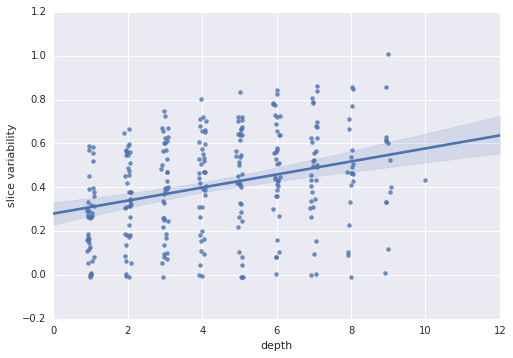

In [8]:
ax = sb.regplot('depth', 'slice variabilities', data=depth_variabilities,
                x_jitter=.1, y_jitter=.01)
ax.set_ylabel('slice variability')
if SAVE_FIGURES:
    ax.figure.savefig('/home/sl/Downloads/gistr/slice-variability_depth_scatter.png', dpi=300)

The same, but with averages at each depth

In [9]:
def plot_slice_variability(**kwargs):
    data = kwargs['data']
    gdata = data.groupby('depth', as_index=False)
    color = sb.color_palette()[0]
    
    x = gdata.first()['depth']
    y = gdata.mean()['slice variabilities']
    ci = gdata['slice variabilities'].aggregate({
            'ci': lambda v: v.std() * 1.96 / np.sqrt(len(v) - 1)
    })['ci']
    
    plt.plot(x, y, color=color)
    plt.fill_between(x, y - ci, y + ci, color=sb.desaturate(color, 0.2), alpha=0.2)

    return plt.gca()

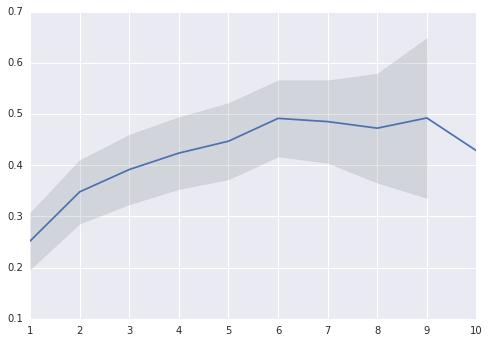

In [10]:
ax = plot_slice_variability(data=depth_variabilities)
if SAVE_FIGURES:
    ax.figure.savefig('/home/sl/Downloads/gistr/slice-variability_depth_average.png', dpi=300)

The same, but with detail for each tree

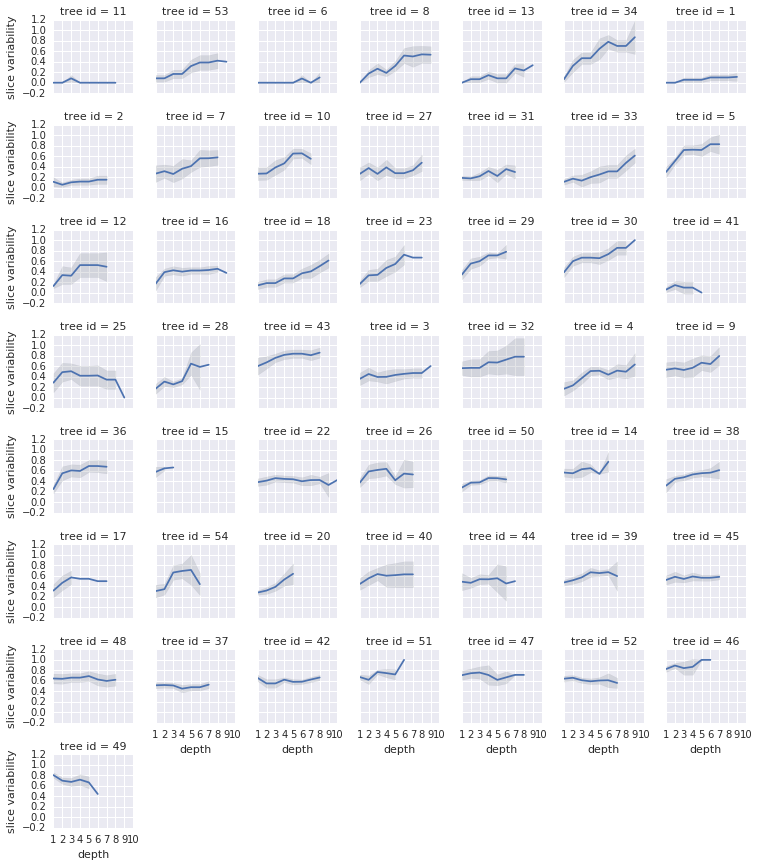

In [12]:
g = sb.FacetGrid(data=data, sharex=True, sharey=True,
                 col='tree id', col_wrap=7, size=1.5,
                 col_order=root_order['tree id'])
g.map_dataframe(plot_slice_variability)
g.set_axis_labels(x_var='depth', y_var='slice variability')
if SAVE_FIGURES:
    g.savefig('/home/sl/Downloads/gistr/slice-variability_depth_per-tree.png', dpi=300)

## 3 Slice MDS ~ depth

TODO